# Week 3: Distributions Continued

## Recall from last week

We are going to continue with our discussion from last week on distributions. To rehash... __there are lots of different distributions__. The most common used in astronomy are the Gaussian (normal), power law, binomial, Poisson, and Lorentz.

When working with a data set we may be faced __two questions__:  
- Is a set of samples consistent with following one of these distributions?  
- Are two sets of samples drawn from the same distribution?  

The tests discussed last week should help us answer these questions. Depending on the situation, __different tests may be appropriate__. The table below should help answer these questions.

### Comparing a data set to a known (analytic) distribution

- $\chi$^2: Widely used, rigorously defined for known, Gaussian uncertainties.
- Kolmogorov-Smirnov (KS): Widely used, compares maximum difference in CDF. Not great for small numbers or outliers.
- Anderson-Darling: Integrated version of the KS test. Therefore better than KS for small numbers and outliers.
- t-test: Determines whether a data set could be consistent with having a mean at some value.

### Comparing two data sets

- Mann-Whitney U (Wilcox rank sum): Assumes nothing about underlying distributions. Really only compares the medians.
- Kolmogorov-Smirnov (KS): Widely used, compares maximum difference in CDF. Not great for small numbers of outliers.
- Anderson-Darling: Integrated version of the KS test. Therefore better than KS for small numbers and outliers.
- t-test: Tests if the means of two (assumed to be Gaussian) distributions equal. Distributions may have different variances - math is slightly different.
- F-test: Tests if the means of two Gaussian distributions are equal.

### Correlation tests

- Pearson r or $\rho$: Widely used, simple to implement. Easily skewed by outliers. Works for linear correlations.
- Spearman r or $\rho$: Handles outliers better. Linear not required -> works for any monotonic function.
- Kendall $\tau$: Also a rank test. Used to determine whether two variables are independent.

## Now, on to a few examples

In [1]:
# First, let's load the libraries we will need
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

### Exercise 1: Characterizing two distributions

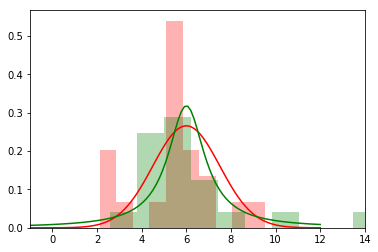

In [74]:
# sample = np.random.normal(loc=4.0, scale=1.5, size=30)
# plt.hist(sample, normed=True)

x = np.linspace(-2, 12.0, 100)


y = stats.norm.pdf(x, loc=6.0, scale=1.5)
plt.plot(x, y, color='r')
y = stats.norm.rvs(loc=6.0, scale=1.5, size=20)
plt.hist(y, normed=True, color='r', 
         alpha=0.3)
np.savetxt("../data/Week_3/sample_1.dat", y)


y = stats.cauchy.pdf(x, loc=6.0, scale=1.0)
plt.plot(x,y, color='g')
y = stats.cauchy.rvs(loc=6.0, scale=1.0, size=20)
plt.hist(y, normed=True, color='g', alpha=0.3)
np.savetxt("../data/Week_3/sample_2.dat", y)


plt.xlim(-1.0, 14.0)
plt.show()

In [77]:
folder = "../data/Week_3/"

sample_1 = np.genfromtxt(folder + "sample_1.dat")
sample_2 = np.genfromtxt(folder + "sample_2.dat")

# Let's see how big the data sets are
print("Data set 1 has", len(sample_1), "elements")
print("Data set 2 has", len(sample_2), "elements")

Data set 1 has 20 elements
Data set 2 has 20 elements


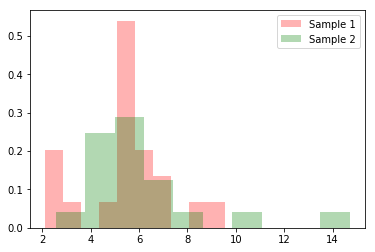

In [80]:
# Now, let's plot histograms of the two data set to see how they compare
plt.hist(sample_1, normed=True, color='r', alpha=0.3, label="Sample 1")
plt.hist(sample_2, normed=True, color='g', alpha=0.3, label="Sample 2")

plt.legend()
plt.show()

First, let's see if these two data sets are consistent with being a Gaussian. Let's start with Sample 1.

In [85]:
# We will use the Anderson-Darling test in the scipy package.

statistic, critical_values, significance = stats.anderson(sample_1, dist='norm')

print("Statistic =", statistic)
print("Critical values =", critical_values)
print("Significance =", significance)

Statistic = 0.685250007509
Critical values = [ 0.506  0.577  0.692  0.807  0.96 ]
Significance = [ 15.   10.    5.    2.5   1. ]


Since the statistic, 0.685, is larger than 0.577 but smaller than 0.692, the distribution is non-Gaussian only at the 90% to 95% level. The statistic would have to be above 0.96 to be ruled non-Gaussian at the 99% level.

In [84]:
# In this code cell, repeat the same test above with Sample 2




Now, let's compare the two distributions to each other. Pick two of the tests above and apply them. 

Remember that in jupyter, it is easy to look up the docs for packages and functions. Look at the following code blocks examples.

In [3]:
stats?

In [88]:
stats.uniform?

In [96]:
statistic, critical_values, significance = stats.anderson_ksamp([sample_1, sample_2])
print("Anderson-Darling Test:")
print("Statistic =", statistic)
print("Critical values =", critical_values)
print("Significance =", significance)
print()

statistic, p_value = stats.ks_2samp(sample_1, sample_2)
print("Kolmogorov-Smirnov:")
print("Statistic =", statistic)
print("p-value =", p_value)

Anderson-Darling Test:
Statistic = -0.473498369492
Critical values = [ 0.325  1.226  1.961  2.718  3.752]
Significance = 0.5729511648872668

Kolmogorov-Smirnov:
Statistic = 0.25
p-value = 0.497342335314


/usr/local/lib/python3.5/dist-packages/scipy/stats/morestats.py:1685: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


### Example 2: Using radial velocities to constrain an unseen companion to a star

This is an example from my own research. 

Let's say you have a star that looks strange for some reason, and you want to know that could be because the star is actually a binary system. A faint companion will not appear in the photometry or spectroscopy. However, by taking radial velocities the possibility that the star hosts a companion can be constrained.

First, let's load up the radial velocity data and look at it.

In [103]:
RV = np.genfromtxt(folder + "RV_sample.dat", names=True)

print(RV.dtype)

[('date', '<f8'), ('vel', '<f8'), ('err', '<f8'), ('file_', '<f8')]


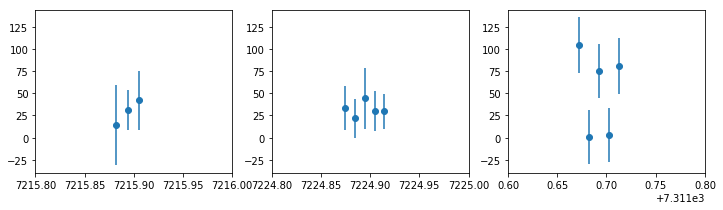

In [117]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))

ax[0].errorbar(RV["date"], RV['vel'], yerr=RV['err'], fmt='o')
ax[0].set_xlim(7215.8, 7216)

ax[1].errorbar(RV["date"], RV['vel'], yerr=RV['err'], fmt='o')
ax[1].set_xlim(7224.8, 7225.0)

ax[2].errorbar(RV["date"], RV['vel'], yerr=RV['err'], fmt='o')
ax[2].set_xlim(7311.6, 7311.8)


plt.show()

Notice the x-axis scale above. There are three different nights of observations with only a handful of observations each night.

We want to know if this data is consistent with a single radial velocity.

## Something new: The Central Limit Theorem (CLT)

Why are Gaussian distributions so common in nature? 

Sample from an arbitrary distribution f(x), say N samples, and take their mean. The mean will not necessarily be the same as the mean of f(x). But if you repeat this a number of times, you'lee see that the sample means are distributed *normally* around the mean of f(x) with a standard deviation: $\sigma_N = \sigma_{f(x)}/\sqrt{N}$, where $\sigma_{f(x)}$ is the spread of the original distribution.

Assumptions: 
* initial distribution has well-defined standard deviation (tails fall of more rapidly than x^-2)
* data are uncorrelated

### CLT example

1. Let's see how the spread of the sample mean changes with the number of samples N. For this example, we will draw many samples from a 'well-behaved' distribution with different sample sizes and see how the sample means are distributed

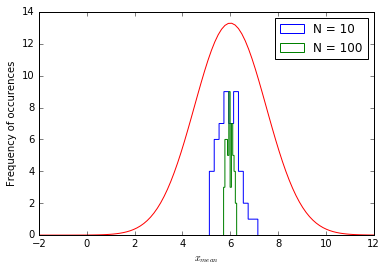

In [51]:
# Select mean and spread of parent distribution f(x)
parent_mean = 6.0
parent_spread = 1.5

# Number of samples to average
N = 10
# Draw samples several times to see distribution
# define empty list to store sample means
sample_means = []
# Repeat drawing samples and averaging this many times
Nrepeats = 50

for i in range(Nrepeats):
    # draw N samples
    y = stats.norm.rvs(loc=parent_mean, scale=parent_spread, size=N)
    # compute their mean
    y_mean = np.mean(y)
    # collect mean in a list
    sample_means.append(y_mean)
    
# Now select other number of samples to compare
N_2 = 100
# define empty list to store sample means
sample_means_2 = []
for i in range(Nrepeats):
    y = stats.norm.rvs(loc=parent_mean, scale=parent_spread, size=N_2)
    y_mean = np.mean(y)
    sample_means_2.append(y_mean)
    
# Plot histogram of sample means for both cases of N
plt.hist(sample_means, histtype = 'step', label = 'N = %d'%N,  bins = 10)
plt.hist(sample_means_2, histtype = 'step', label = 'N = %d'%N_2,  bins = 10)
# plot also original distribution
x = np.linspace(-2, 12.0, 100)
plt.plot(x,stats.norm.pdf(x, loc = parent_mean, scale = parent_spread)*Nrepeats)
plt.legend()
plt.xlabel('$x_{mean}$')
plt.ylabel('Frequency of occurences')
plt.show()

Bonus: the more you repeat the excercise, the more the distribution of sample means approaches Gaussianity (repeat with 500 iterations).

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in divide


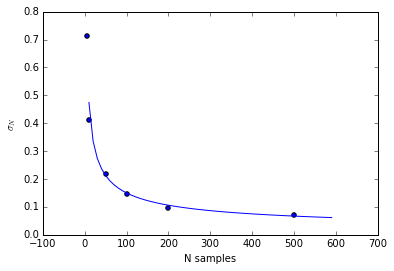

In [57]:
Ns = [5,10,50,100,200,500]
spread = []
for N in Ns:
    sample_means = []
    # Repeat drawing samples and averaging this many times
    Nrepeats = 100
    for i in range(Nrepeats):
        # draw N samples
        y = stats.norm.rvs(loc=parent_mean, scale=parent_spread, size=N)
        # compute their mean
        y_mean = np.mean(y)
        # collect mean in a list
        sample_means.append(y_mean)
    spread.append(np.std(sample_means))
    
# Plot spread of sample means versus N samples
plt.scatter(Ns, spread)
xs = np.arange(0,600,10)
plt.plot(xs, parent_spread/np.sqrt(xs))
plt.ylabel('$\sigma_N$')
plt.xlabel('N samples')
plt.show()